# import data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
from __future__ import print_function


In [2]:
#display the full dataframe for all cells
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)
# display(df)

In [3]:
PROJ_ROOT = os.pardir
print(PROJ_ROOT)
import sys
src_dir = os.path.join(PROJ_ROOT, "src")
sys.path.append(src_dir)

..


In [4]:
from config import TRAIN_FILE_PATH, TEST_FILE_PATH
from features.build_features import read_tsv_file
train = read_tsv_file(TRAIN_FILE_PATH)
test = read_tsv_file(TEST_FILE_PATH)
print(train.shape, test.shape)

(161297, 7) (53766, 7)


join the two datasets 

In [5]:
df = pd.concat([train, test], ignore_index = True)
df.sample(2)

,id,drugName,condition,review,rating,date,usefulCount
154844,153945,Vivitrol,Opiate Dependence,"""I was a heroin addict for four years. I went through inpatient rehab twice and outpatient once. My family was at the end of their rope. In a final &quot;Hail Mary,&quot; my parents decided to give Vivitrol a try (in conjunction with group and individual therapy sessions). I have been clean from all opiates for 18 months now. The turn around I&#039;ve made in my life is remarkable. Medication used to treat addiction is tricky, because it will not work unless the patient truly wants to get clean. Nothing will stop an addict who wants to use from using. The only side effects I&#039;ve experienced have been mild sleep disruption, but I am glad to be awake and sober rather than sound asleep and an addict.""",9.0,"June 17, 2014",157
116236,12462,Ortho Micronor,Birth Control,"""I started taking Micronor pill after the Cerell pill didn&#039;t agree with me. I was on Micronor for 3 weeks and had to stop it, I was getting different side effects, my breasts were so sore I could barely touch them and I was getting cramp constantly (upto the point I was taking tablets every four hours) and then I started getting really weird cramps which I can only describe as contractions, I felt hot and sweaty with these pains and felt like I was going to pass out, I stopped taking it after I had 3 of these attacks as it was making me feel unwell. Has anyone else had this side effect on Micronor pill? I haven&#039;t had any since stopping this pill. The only good thing about it was it did actually stop the bleeding.""",1.0,"August 10, 2016",8


Several data wrangling steps need to perform:
1. the column names are inconsistant, should all change to lower cases.
2. the review contains no words characters, suach as "&#039","\r\n\r\n","+", and capitalize "YOU SHALL NOT PASS". They need to clean up.

# data wrangling

2.1 Know the basics of the datasets:

1. shape of dataset
2. data type
3. data distribution
4. missing value and the way to handle the missing value
5. any duplicates
6. any incorrect or manipulated data?

In [6]:
print(df.shape)
print(df.info())
print(df.isnull().sum())

(215063, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215063 entries, 0 to 215062
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   id           215063 non-null  int64  
 1   drugName     215063 non-null  object 
 2   condition    213869 non-null  object 
 3   review       215063 non-null  object 
 4   rating       215063 non-null  float64
 5   date         215063 non-null  object 
 6   usefulCount  215063 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 11.5+ MB
None
id                0
drugName          0
condition      1194
review            0
rating            0
date              0
usefulCount       0
dtype: int64


there are 1194 missing values in "condition", also the data type for rating should be int instead of float, the date should change to time.

In [7]:
df['rating'] = df['rating'].astype('int')
df['date'] = pd.to_datetime(df['date'])
df.set_index('date',inplace = True)
df.head()

,id,drugName,condition,review,rating,usefulCount
date,,,,,,
2012-05-20,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combination of Bystolic 5 Mg and Fish Oil""",9,27
2010-04-27,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of Intuniv. We became concerned when he began this last week, when he started taking the highest dose he will be on. For two days, he could hardly get out of bed, was very cranky, and slept for nearly 8 hours on a drive home from school vacation (very unusual for him.) I called his doctor on Monday morning and she said to stick it out a few days. See how he did at school, and with getting up in the morning. The last two days have been problem free. He is MUCH more agreeable than ever. He is less emotional (a good thing), less cranky. He is remembering all the things he should. Overall his behavior is better. \r\nWe have tried many different medications and so far this is the most effective.""",8,192
2009-12-14,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, which had 21 pill cycle, and was very happy- very light periods, max 5 days, no other side effects. But it contained hormone gestodene, which is not available in US, so I switched to Lybrel, because the ingredients are similar. When my other pills ended, I started Lybrel immediately, on my first day of period, as the instructions said. And the period lasted for two weeks. When taking the second pack- same two weeks. And now, with third pack things got even worse- my third period lasted for two weeks and now it&#039;s the end of the third week- I still have daily brown discharge.\r\nThe positive side is that I didn&#039;t have any other side effects. The idea of being period free was so tempting... Alas.""",5,17
2015-11-03,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth control. I&#039;m glad I went with the patch, I have been on it for 8 months. At first It decreased my libido but that subsided. The only downside is that it made my periods longer (5-6 days to be exact) I used to only have periods for 3-4 days max also made my cramps intense for the first two days of my period, I never had cramps before using birth control. Other than that in happy with the patch""",8,10
2016-11-27,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around. I feel healthier, I&#039;m excelling at my job and I always have money in my pocket and my savings account. I had none of those before Suboxone and spent years abusing oxycontin. My paycheck was already spent by the time I got it and I started resorting to scheming and stealing to fund my addiction. All that is history. If you&#039;re ready to stop, there&#039;s a good chance that suboxone will put you on the path of great life again. I have found the side-effects to be minimal compared to oxycontin. I&#039;m actually sleeping better. Slight constipation is about it for me. It truly is amazing. The cost pales in comparison to what I spent on oxycontin.""",9,37


change the unique values of numeric columns.

In [8]:
print(df.rating.unique())
print(df.describe())

[ 9  8  5  2  1 10  4  3  7  6]
                  id         rating    usefulCount
count  215063.000000  215063.000000  215063.000000
mean   116039.364814       6.990008      28.001004
std     67007.913366       3.275554      36.346069
min         0.000000       1.000000       0.000000
25%     58115.500000       5.000000       6.000000
50%    115867.000000       8.000000      16.000000
75%    173963.500000      10.000000      36.000000
max    232291.000000      10.000000    1291.000000


 There are 10 unique rating from 1 to 10.  The average rating is 6.99, with the 25% to 75% in 5 to 10, suggesing rating is skewed. 
 the mean "usefulCount" is 28 while the max can reach to 1291 suggesting the usefulCount is widespread. 

Data cleaning 

missing values

In [9]:
missing_values = df["condition"].isna()
df[missing_values].head()

,id,drugName,condition,review,rating,usefulCount
date,,,,,,
2010-08-18,51452,Azithromycin,NaN,"""Very good response. It is so useful for me. """,10,1
2011-07-02,61073,Urea,NaN,"""Accurate information.""",10,13
2010-10-20,132651,Doxepin,NaN,"""So far so good. Good for me and I can take it everyday. Can&#039;t remember the last time I slept 7 hours straight.""",10,25
2011-01-24,44297,Ethinyl estradiol / norgestimate,NaN,"""I haven&#039;t been on it for a long time and I have suffered from severe nausea and have thrown up twice. My appetite has lessened even more so than it was before. My acne has gone down and my boobs have grown a lot. Although I have thrown up, if it&#039;s for acne I would suggest it.""",8,1
2017-03-23,68697,Medroxyprogesterone,NaN,"""I started the shot in July 2015 and ended in January 2017. Initially, I had pretty bad headaches, hot flashes, hair loss (nothing that anyone but me noticed), and quite a bit of bleeding (about 3 weeks after my first shot). After, about a month, the side affects started to wane - I stopped bleeding almost entirely (yasss!) and stopped losing hair. That said, while I did not have initial weight gain, I have gained about 15 pounds in the last year (I have never gained this much weight in this amount of time). As a result of the weight gain alone, I am discontinuing with this method of birth control.""",6,1


In [10]:
missing_value_ratio = df.isna().sum()/len(df)*100
print(round(missing_value_ratio,2))

id             0.00
drugName       0.00
condition      0.56
review         0.00
rating         0.00
usefulCount    0.00
dtype: float64


only 0.56% missing values, and the review of  it is safe to drop it.

In [11]:
df = df.dropna()
print(df.shape)
# check duplicate of data
print (df.duplicated(subset =["review"]).sum())
print (df.duplicated(subset =["review","condition","rating","usefulCount"]).sum())

(213869, 6)
85420
84711


In [12]:
duplicate_rows = df[df.duplicated(subset=["review","condition","rating","usefulCount"])]
duplicate_rows.head()

,id,drugName,condition,review,rating,usefulCount
date,,,,,,
2017-04-21,109101,Nexplanon,Birth Control,"""First had implanon then got Nexplanon, had a period first month and I have not had one since. I&#039;m due to remove it next year. I do notice spotting sometimes for a day but it honestly usually coincides with when I&#039;m stressed. \r\nHad some weight gain also.\r\n\r\nSo far the best BC I&#039;ve had in all my years. I plan on trying for a baby next year then I will be back on it.""",9,5
2010-09-05,183531,Cymbalta,Anxiety,"""Prescribed via a Psychiatrist for severe Panic attacks for 2 years.\r\nIf I take dosage late or forget to take it the withdrawal symptoms kick in. \r\nGnawing physical pain, breathlessness, disorientation to time, difficulties in word finding while speaking, severe muscle pain and stiffness, nausea, labile emotions and panic.\r\n\r\n""",1,27
2015-10-08,5154,Orsythia,Birth Control,"""I have only been on orsythia for about 1 month and I just started my second week of my second month. I guess I didn&#039;t notice earlier but I started to get slight headaches and I didn&#039;t feel very well physically and mentally. It do help with my cramps and my period, not so much my acne but it&#039;s better. The worst part of orsythia has to be the mood swings and the sweating! I sweat a lot even if it&#039;s cold I&#039;ll start a light sweat, it&#039;s gross. But the mood swings are the worst I just started feeling this and it happened while I was talking to one of my friends I just blew up on him, for no reason. Then later on I started to feel really bad(mentally) and I cried for a while and I couldn&#039;t figure out why I was crying! I don&#039;t recommend!""",2,7
2013-11-01,186190,Desvenlafaxine,Depression,"""I have suffered from severe anxiety (GAD) and was taking more and more Klonopin as time went on. I am very sensitive to medication and have tried many different SSRI/SNRI&#039;s through the year with horrible side effects. Finally, I had DNA testing to see what I would respond to and the result was Pristiq. I started it several months ago in a small dose (I split the pills even though they say don&#039;t do this) and within a few days my anxiety literally went away. I was able to cut my Klonopin in 1/2 over a two month period. The first week or two I was extremely tired but that passed. The only side effect I get from time to time is migraines. It still amazes me that my anxiety has disappeared. I no longer keep Klonopin in my pocket!""",8,81
2012-02-01,73940,Ethinyl estradiol / norethindrone,Birth Control,"""I have been taking my first pack of Lo Loestrin Fe and I must say it really works for me. I was a little nervous at first because this is my first time taking birth control and I&#039;ve heard all the negative side effects of taking birth control. I have had spotting [brown-ish color] for three weeks after my period, but that&#039;s normal for the first month. I have breast tenderness and mood swings every now and then, then again it&#039;s expected for the first few months. I have not yet experienced any weight gain. So far I am satisfied, but I wish it wasn&#039;t so expensive.""",8,7


There are 85420 duplicated in "reviews", for each pair of duplicates, they share the same "condition", while varied in "drugname". Therefore, the duplicate data will be dropped.

In [13]:
df = df.drop_duplicates(subset=["review","condition","rating","usefulCount"], keep="first")
df.shape

(129158, 6)

Cleaning "condition" column

In [14]:
df.condition.unique()

array(['Left Ventricular Dysfunction', 'ADHD', 'Birth Control',
       'Opiate Dependence', 'Benign Prostatic Hyperplasia',
       'Emergency Contraception', 'Bipolar Disorde', 'Epilepsy',
       'Migraine Prevention', 'Depression', "Crohn's Disease", 'Cough',
       'Obesity', 'Urinary Tract Infection', 'ibromyalgia',
       'Chronic Myelogenous Leukemia', 'HIV Infection', 'Insomnia',
       'Rheumatoid Arthritis', 'Vaginal Yeast Infection',
       'Chlamydia Infection', 'Hirsutism', 'Panic Disorde', 'Migraine',
       'Pain', 'Irritable Bowel Syndrome', 'Osteoarthritis',
       'Constipation', 'Bowel Preparation', 'Psychosis', 'Muscle Spasm',
       'Hepatitis C', 'Overactive Bladde', 'Diabetes, Type 2',
       'Asthma, Maintenance', 'Non-Small Cell Lung Cance',
       'Schizophrenia', 'Dysuria', 'Smoking Cessation', 'Anxiety', 'Acne',
       'emale Infertility', 'Constipation, Acute',
       'Constipation, Drug Induced', 'Erectile Dysfunction',
       'Trigeminal Neuralgia', 'Undera

some conditions list are comments which can't represent the real conditions, and should be removed form the dataset. Also, some typos such as "Cance", "Disorde", and incomplete information (e.g "eve", which should be "fever")

In [15]:
#remove the comments in conditions
condition_mask = df.condition.str.contains("users found this comment helpful")

df=df[~condition_mask]
df.shape
print(df.head())

                id                  drugName                     condition  \
date                                                                         
2012-05-20  206461                 Valsartan  Left Ventricular Dysfunction   
2010-04-27   95260                Guanfacine                          ADHD   
2009-12-14   92703                    Lybrel                 Birth Control   
2015-11-03  138000                Ortho Evra                 Birth Control   
2016-11-27   35696  Buprenorphine / naloxone             Opiate Dependence   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

In [16]:
df.condition.unique()

array(['Left Ventricular Dysfunction', 'ADHD', 'Birth Control',
       'Opiate Dependence', 'Benign Prostatic Hyperplasia',
       'Emergency Contraception', 'Bipolar Disorde', 'Epilepsy',
       'Migraine Prevention', 'Depression', "Crohn's Disease", 'Cough',
       'Obesity', 'Urinary Tract Infection', 'ibromyalgia',
       'Chronic Myelogenous Leukemia', 'HIV Infection', 'Insomnia',
       'Rheumatoid Arthritis', 'Vaginal Yeast Infection',
       'Chlamydia Infection', 'Hirsutism', 'Panic Disorde', 'Migraine',
       'Pain', 'Irritable Bowel Syndrome', 'Osteoarthritis',
       'Constipation', 'Bowel Preparation', 'Psychosis', 'Muscle Spasm',
       'Hepatitis C', 'Overactive Bladde', 'Diabetes, Type 2',
       'Asthma, Maintenance', 'Non-Small Cell Lung Cance',
       'Schizophrenia', 'Dysuria', 'Smoking Cessation', 'Anxiety', 'Acne',
       'emale Infertility', 'Constipation, Acute',
       'Constipation, Drug Induced', 'Erectile Dysfunction',
       'Trigeminal Neuralgia', 'Undera

In [17]:
repl_dict1 = {
    'emale Infertility': 'Female Infertility',
    'atigue':'Fatigue',
    'Not Listed / Othe': 'Not Listed Other',
    'moterol)':'Formoterol Mometasone',
    't Pac with Cyclobenzaprine (cyclobenzaprine)':
    'Comfort Pac with Cyclobenzaprine',
    'zen Shoulde': 'Frozen Shoulder',
    'mis': 'Mist',
    'tic (mycophenolic acid)': 'Mycophenolic Acid',
    'ailure to Thrive': 'Failure To Thrive',
    'm Pain Disorde': 'Pain Disorder',
    'mist (': 'Mist',
    'me': 'Mist',
    'lic Acid Deficiency': 'Folic Acid Deficiency',
    'min / saxagliptin)': 'Metformin Saxagliptin',
    'ge HCT (amlodipine / hydrochlorothiazide / valsartan)':
    'Amlodipine Hydrochlorothiazide Valsartan',
    'moterol / mometasone)':'Formoterol Mometasone',
    'eve':'Fever',
    'mance Anxiety':'Performance Anxiety',
    'min)':'Metformin Saxagliptin',
    'ge (amlodipine / valsartan)':'Amlodipine Valsartan',
    'min / rosiglitazone)':'Metformin Rosiglitazone',
    'llicular Lymphoma':'Follicular Lymphoma',
    'min / pioglitazone)':'Metformin Pioglitazone',
    'Pe':"Performance Anxiety",
    't Care':'Urgent Care',
    'llicle Stimulation':'Follicle Stimulation',
}

In [18]:
df.replace({"condition": repl_dict1},inplace=True)

In [19]:
df.condition.unique()

array(['Left Ventricular Dysfunction', 'ADHD', 'Birth Control',
       'Opiate Dependence', 'Benign Prostatic Hyperplasia',
       'Emergency Contraception', 'Bipolar Disorde', 'Epilepsy',
       'Migraine Prevention', 'Depression', "Crohn's Disease", 'Cough',
       'Obesity', 'Urinary Tract Infection', 'ibromyalgia',
       'Chronic Myelogenous Leukemia', 'HIV Infection', 'Insomnia',
       'Rheumatoid Arthritis', 'Vaginal Yeast Infection',
       'Chlamydia Infection', 'Hirsutism', 'Panic Disorde', 'Migraine',
       'Pain', 'Irritable Bowel Syndrome', 'Osteoarthritis',
       'Constipation', 'Bowel Preparation', 'Psychosis', 'Muscle Spasm',
       'Hepatitis C', 'Overactive Bladde', 'Diabetes, Type 2',
       'Asthma, Maintenance', 'Non-Small Cell Lung Cance',
       'Schizophrenia', 'Dysuria', 'Smoking Cessation', 'Anxiety', 'Acne',
       'Female Infertility', 'Constipation, Acute',
       'Constipation, Drug Induced', 'Erectile Dysfunction',
       'Trigeminal Neuralgia', 'Under

In [20]:
repl_dict = {" Disorde$":' Disorder', 'Cance$': 'Cancer',' Cance$': ' Cancer',' Tum$':' Tumor', ' Feve$':' Fever',' Ulce$': ' Ulcer', ' Bladde$':' Bladder'}

In [21]:
df.replace({"condition": repl_dict},regex= True,inplace=True)

In [22]:
import string
def remove_punctuations(text):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, '')
    return text.lower()

In [23]:
df["condition"] = df['condition'].apply(remove_punctuations)
df.condition.unique()

array(['left ventricular dysfunction', 'adhd', 'birth control',
       'opiate dependence', 'benign prostatic hyperplasia',
       'emergency contraception', 'bipolar disorder', 'epilepsy',
       'migraine prevention', 'depression', 'crohns disease', 'cough',
       'obesity', 'urinary tract infection', 'ibromyalgia',
       'chronic myelogenous leukemia', 'hiv infection', 'insomnia',
       'rheumatoid arthritis', 'vaginal yeast infection',
       'chlamydia infection', 'hirsutism', 'panic disorder', 'migraine',
       'pain', 'irritable bowel syndrome', 'osteoarthritis',
       'constipation', 'bowel preparation', 'psychosis', 'muscle spasm',
       'hepatitis c', 'overactive bladder', 'diabetes type 2',
       'asthma maintenance', 'nonsmall cell lung cancer', 'schizophrenia',
       'dysuria', 'smoking cessation', 'anxiety', 'acne',
       'female infertility', 'constipation acute',
       'constipation drug induced', 'erectile dysfunction',
       'trigeminal neuralgia', 'underac

<Figure size 1000x600 with 0 Axes>

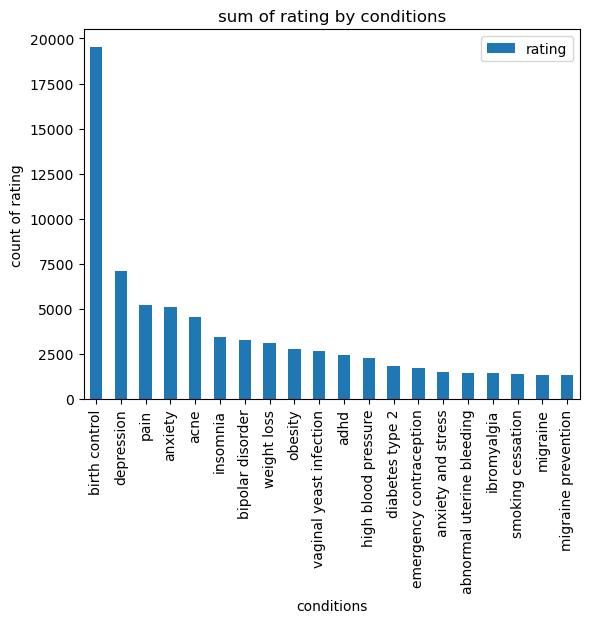

In [24]:
rating_by_condition = df.groupby('condition').agg({'rating':'count'}).sort_values(by ='rating',ascending = False)
rating_by_condition = rating_by_condition.nlargest(20, 'rating')
# visualize the results
plt.figure(figsize =(10,6))
rating_by_condition.plot(kind='bar')
plt.title('sum of rating by conditions')
plt.xlabel('conditions')
plt.ylabel('count of rating')
plt.show()

The'birth control', 'depression','pain', 'anxiety' are the conditions have most of rating. 

In [25]:
drugName_list = df.drugName.unique().tolist()
print(len(drugName_list))
print(drugName_list)

3168
['Valsartan', 'Guanfacine', 'Lybrel', 'Ortho Evra', 'Buprenorphine / naloxone', 'Cialis', 'Levonorgestrel', 'Aripiprazole', 'Keppra', 'Ethinyl estradiol / levonorgestrel', 'Topiramate', 'L-methylfolate', 'Pentasa', 'Dextromethorphan', 'Nexplanon', 'Liraglutide', 'Trimethoprim', 'Amitriptyline', 'Lamotrigine', 'Nilotinib', 'Atripla', 'Trazodone', 'Etonogestrel', 'Etanercept', 'Tioconazole', 'Azithromycin', 'Eflornithine', 'Daytrana', 'Ativan', 'Imitrex', 'Sertraline', 'Toradol', 'Viberzi', 'Mobic', 'Dulcolax', 'Morphine', 'MoviPrep', 'Trilafon', 'Fluconazole', 'Contrave', 'Clonazepam', 'Metaxalone', 'Venlafaxine', 'Ledipasvir / sofosbuvir', 'Symbyax', 'Tamsulosin', 'Doxycycline', 'Dulaglutide', 'Intuniv', 'Buprenorphine', 'Qvar', 'Opdivo', 'Pyridium', 'Latuda', 'Bupropion', 'Implanon', 'Effexor XR', 'Drospirenone / ethinyl estradiol', 'NuvaRing', 'Prepopik', 'Tretinoin', 'Gildess Fe 1 / 20', 'Ethinyl estradiol / norgestimate', 'Elbasvir / grazoprevir', 'Clomiphene', 'Docusate / sen

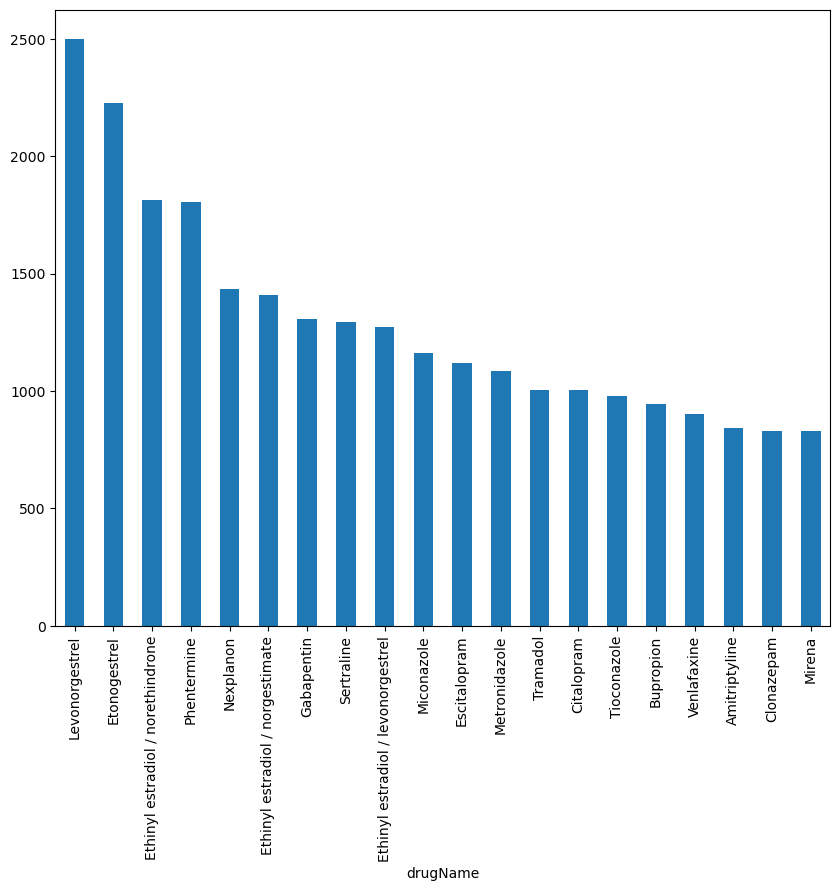

In [26]:
plt.figure(figsize = (10,8))
top_drugName = df['drugName'].value_counts(ascending = False).nlargest(20)

top_drugName.plot(kind ='bar')
plt.show()

what are the top 20 drugs with the highest rating

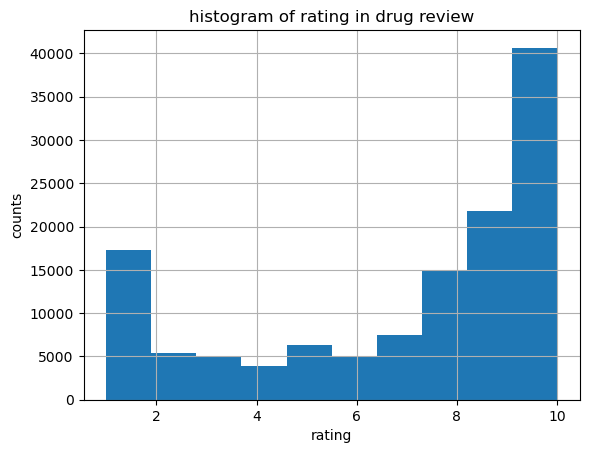

In [27]:
df['rating'].hist(bins=10)
plt.title('histogram of rating in drug review')
plt.xlabel("rating")
plt.ylabel("counts")
plt.show()

rating_category
positive    70.032085
neutral     17.057255
negative    12.910660
Name: proportion, dtype: float64


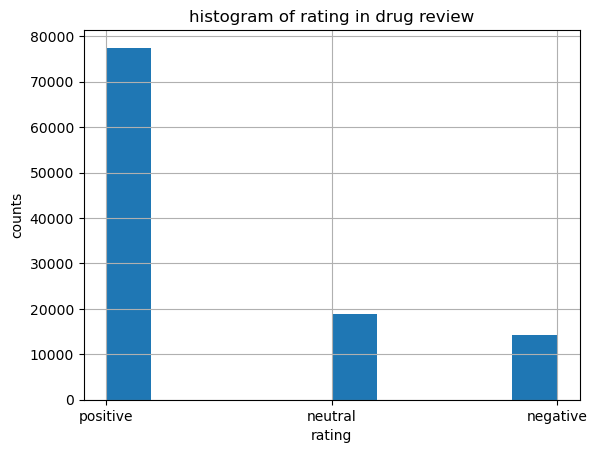

In [28]:
df['rating_category'] =pd.cut(df['rating'], bins = [1,4,7,10],labels = ['negative','neutral','positive'])
print(df['rating_category'].value_counts(normalize = True)*100)

df['rating_category'].hist(bins=10)
plt.title('histogram of rating in drug review')
plt.xlabel("rating")
plt.ylabel("counts")
plt.show()

The rating is not eqully distributed, about 70% positive rating, only 17 % and 13% neutral and negative rating. The data is imbalanced.

visulaize the distribution of 'usefulCount'.

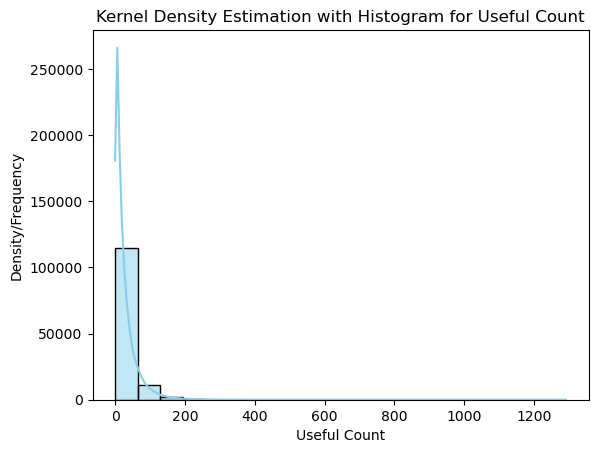

In [29]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
sns.histplot(df['usefulCount'], kde=True, bins=20, color='skyblue', edgecolor='black')
plt.title('Kernel Density Estimation with Histogram for Useful Count')
plt.xlabel('Useful Count')
plt.ylabel('Density/Frequency')

plt.show()

## feature engineering and preprocessing

In [30]:
import spacy
import nltk
import re
from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from textblob import TextBlob
import contractions 

In [49]:
def remove_special_characters(text):
    text = text.lower()
    text = text.replace('&#039', '').replace('\n','').replace('\r', '')
    text = text.replace(r'[^\w\d\s]',' ')
    pattern = re.compile(r'[^a-zA-z0-9\s]+')
    cleaned_text = re.sub(pattern, '', str(text))
    cleaned_text =' '.join(word.strip() for word in cleaned_text.split())
    return cleaned_text                

In [46]:

raw_text = "&#039;ve been super irritable/moody,500mg Amoxicillin (3x/day)    co \r\nWe have triedand I don&#039;t understand \n\d how the 1/2 side effects can be so extreme for me when I previously was on Nor-Qd "
text = remove_special_characters(raw_text)
text

've been super irritablemoody500mg amoxicillin 3xday co we have triedand i dont understand \\d how the 12 side effects can be so extreme for me when i previously was on norqd'

In [39]:
def text_lowercase(text):
    return text.lower()

In [40]:
# df['review'].iloc[:5].apply(text_lowercase)
# didon't work on df?

In [41]:
tx = text_lowercase(raw_text)
tx

'&#039;ve been super irritable/moody,500mg amoxicillin (3x/day) co \r\nwe have triedand i don&#039;t understand \n\\d how the 1/2 side effects can be so extreme for me when i previously was on nor-qd '

In [42]:
import infect
p = inflect.engine()
# convert number into words
def convert_number(text):
    temp_text = text.split()
    new_text = []
    for word in temp_text:
        if word.isdigit():
            temp = plnumber_to_words(word)
            new_text.append(temp)
        else:
            new_text.append(word)
    temp_text = ' '.join(new_text)
    return temp_text
    

ModuleNotFoundError: No module named 'infect'

In [47]:
def remove_whitespace(text):
    return ' '.join(text.split())

In [48]:
remove_whitespace(raw_text)

'&#039;ve been super irritable/moody,500mg Amoxicillin (3x/day) co We have triedand I don&#039;t understand \\d how the 1/2 side effects can be so extreme for me when I previously was on Nor-Qd'

In [ ]:
def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))

In [ ]:
# import contractions 
def expand_contractions(text):
    cleaned_text = contractions.fix(text)
    return cleaned_text

In [ ]:

tx = expand_contractions(text)
tx

In [ ]:
import en_core_web_sm
nltk.download('stopwords')
from nltk.corpus import stopwords
nlp= spacy.load('en_core_web_sm')
#tokenizer = ToktokTokenizer()
stop_words = set(stopwords.words('english'))


### remove special characters

what are the top words in review? build a word count plot:

In [ ]:
from collections import Counter
stop_words = set(stopwords.words('english'))
df['review'] = df['review'].str.lower()
text = df['review'].apply(lambda x: ' '.join(word for word in x.split() if word not in stop_words))
tokens = word_tokenize(text)
count = Counter(tokens)
v,counts = zip(count*.most_common(10))
plt.bar(v,count)
plt.xlabel("word")
plt.ylabel("counts")
plt.title("Top words in drug review")
plt.show()




In [ ]:
#check what are the top conditions.
top_conditions = df.condition.value_counts().head(30)
top_conditions.plot(kind = "bar")

In [ ]:
chunk_size = 50000
chunks = [df[i:i + chunk_size] for i in range(0, len(df), chunk_size)]
result = pd.concat([chunk.groupby('condition').agg({'rating':'sum','usefulcount':'sum'}) for chunk in chunks])